cloning the github repo cotaining the dataset

In [ ]:
!git clone https://github.com/mehdi-nait/Heart-Failure-Symptomes-detection.git

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import Augmentor
#!pip install wandb
#import wandb


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Constructing Dataset class

## Data Augmentation using Augmentor 

In [ ]:
images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

NUM_SAMPLES = 3000

images = os.listdir(images_path)
labels = os.listdir(labels_path)

print(f"init size : {len(images)}")

images = [images_path+X for X in images]
labels = [labels_path+X for X in labels]

collected = list(zip(images,labels))

images = [[np.asarray(Image.open(y)) for y in x] for x in collected]

p = Augmentor.DataPipeline(images)

p.random_distortion(0.8,grid_height=15,grid_width=15,magnitude=5)
p.rotate(1, max_left_rotation=5, max_right_rotation=5)
p.flip_top_bottom(0.5)
p.zoom_random(0.5, percentage_area=0.7)

augmented_images= p.sample(NUM_SAMPLES)

for i in range(len(augmented_images)):
  
  cv2.imwrite(f"{images_path}{i}.png", augmented_images[i][0])
  cv2.imwrite(f"{labels_path}{i}.png", augmented_images[i][1])


print(f"end size : {len(os.listdir(images_path))}")


In [3]:
images_path = "Data/Dataset/Train/Images/" 
labels_path = "Data/Dataset/Train/Labels/"

images = os.listdir(images_path)
labels = os.listdir(labels_path)

print(len(images))
print(len(labels))
images = [images_path+X for X in images]
labels = [labels_path+X for X in labels]

for image in images:
  image = cv2.imread(image)
  image = cv2.resize(image,(150,150))

for image in labels:
  image = cv2.imread(image)
  image = cv2.resize(image,(150,150))

3526
3526


## Dataset class

In [4]:
class Dataset_seg(Dataset):
    """A class used to represent the dataset
    
    Attributes
    ----------

    images : list(str)
        a list of image paths 
    labels : list(str)
        list of labels paths
    size_img : tuple(int,int)
        image and label size
    transform : function
        transformation to be applied on the images/labels
    
    Methods
    -------
    __init__(self,image_dir,label_dir,transform = None)
        instanciates the dataset object
    __len__(self)
        returns the length of the dataset
    __getitem__(self,idx)
        returns a image,label matrices couple after transforamations

    """
    
    def __init__(self,image_dir,label_dir,transform = None):

        
        self.images = os.listdir(image_dir)
        self.images = [image_dir+x for x in self.images]
        
        self.labels = os.listdir(label_dir)
        self.labels = [label_dir+x for x in self.labels]
        self.transform = transform
        self.size_img = (256,256)
        
    def __len__(self):

        return len(self.images)
    
    def __getitem__(self,idx):

        image = cv2.imread(self.images[idx], cv2.IMREAD_GRAYSCALE)
        label = cv2.imread(self.labels[idx], cv2.IMREAD_GRAYSCALE)
        
        image = cv2.resize(image,self.size_img)
        label = cv2.resize(label,self.size_img)
        
        image = cv2.equalizeHist(image)
        label = cv2.equalizeHist(label)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        image = image.to(device)
        label = label.to(device)
        return image,label
        
        

# Building U-Net Model

Inspired from O. Ronneberger, P. Fischer, and T. Brox, “U-net: Convolutional networks for biomedical 
image segmentation,” 

In [5]:
class Block(nn.Module):
  """"""

  def __init__(self,in_channels,out_channels):
    
    super(Block,self).__init__()

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3)
    self.relu  = nn.LeakyReLU()
    self.drop_out = nn.Dropout2d(p=0.5)
    self.batch_norm = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3)
    

  def forward(self,x):
    
    x = self.conv1(x)
    #x = self.drop_out(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    x = self.conv2(x)
    #x = self.drop_out(x)
    x = self.relu(x)
    x = self.batch_norm(x)
    return x

In [6]:
class Encoder(nn.Module):

  def __init__(self,channels = (1,16,32,64)):
    super(Encoder,self).__init__()

    self.encode_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.pooling = nn.MaxPool2d(2,2)

  def forward(self,x):

    outputs = []

    for block in self.encode_blocks:

      x = block(x)
      outputs.append(x)
      x = self.pooling(x)

    return outputs

In [7]:
class Decoder(nn.Module):

  def __init__(self,channels = (64,32,16)):

    super(Decoder,self).__init__()

    self.channels = channels
    self.drop_out = nn.Dropout2d(p=0.5)
    self.up_convs  = nn.ModuleList(nn.ConvTranspose2d(channels[i],channels[i+1],2,2) for i in range(len(channels)-1))
    self.dec_blocks = nn.ModuleList(Block(channels[i],channels[i+1]) for i in range(len(channels)-1))
    self.batch_norms = nn.ModuleList(nn.BatchNorm2d(channels[i+1]) for i in range(len(channels)-1))

  def forward(self,x,enc_features):

    for i in range(len(self.channels)-1):
      
      x = self.up_convs[i](x)
      #x = self.drop_out(x)
      x = self.batch_norms[i](x)
      enc_feature = self.copy_crop(enc_features[i],x)
      x = torch.cat((enc_feature,x),dim=1)
      x = self.dec_blocks[i](x)

    
    return x


  def copy_crop(self,feature,x):

    _,_,H,W = x.shape
    cropped_feature = transforms.CenterCrop([H,W])(feature)
    return cropped_feature

In [8]:
class Unet(nn.Module):

  def __init__(self, enc_channels = (1,16,32,64), dec_channels = (64,32,16),nb_classes = 1, retainDim = True, out_size=(256,256)):
    super(Unet,self).__init__()

    self.encoder = Encoder(enc_channels)
    self.decoder = Decoder(dec_channels)
    
    self.head = nn.Conv2d(dec_channels[-1], nb_classes, 1)
    self.retainDim = retainDim
    self.outSize = out_size
    self.activation = nn.Sigmoid()
    

  
  def forward(self,x):

    enc_features = self.encoder(x)

    dec_features = self.decoder(enc_features[::-1][0],enc_features[::-1][1:])
		
    map = self.head(dec_features)
    map = self.activation(map)
    
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    
  
    return map

# Defining training metrics (loss & accuracy mesurement)

Here, we're using a Sigmoid Binary Cross Entropy loss function combined with dice loss, which yielded better results for dataset

In [9]:
class SoftDiceLoss(nn.Module):
  
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score
    

In [10]:
class BCE_DiceLoss(nn.Module):
  def __init__(self,weight = None,size_average = True):
    super(BCE_DiceLoss,self).__init__()
    
  def forward(self,logits,targets):
    bce = nn.BCEWithLogitsLoss()
    dice_loss = SoftDiceLoss()
    return bce(logits, targets) + (1-dice_metric(logits, targets))
    

Defining accuracy mesurement metrics, namely Dice coefficient and jaccard's index (Intersection over Union)

In [11]:
def dice_metric(output,label):

  intersection = 2.0* (output*label).sum()
  union = output.sum()+label.sum()

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union

In [12]:
def IoU_metric(output,label):
  
  intersection = (output*label).sum()
  union = output.sum()+label.sum() - intersection

  if output.sum()==0 and label.sum()==0:
    return  1
  
  return intersection/union

# Data preparation, and model training

In [20]:
EPOCHS = 30
BATCH_SIZE = 5
LR = 0.001
MOMENTUM = 0.99
ENC_CHANNELS = (1,16,32,64)
DEC_CHANNELS = (64,32,16)

In [21]:
train_dir = "Data/Dataset/Train/"
valid_dir = "Data/Dataset/Test/"


train_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
valid_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())

valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)


In [22]:
config = {
  "Loss_function" : "BCE_DiceLoss",
  "Optimizer" : "SGD",
  "Learning_rate": LR,
  "Momentum":MOMENTUM,
  "Image_Size" : 256,
  "encoder layers":ENC_CHANNELS,
  "decoder layers":DEC_CHANNELS,
  "Epochs": EPOCHS,
  "Batch_size": BATCH_SIZE,
  "Device" : device
}

#wandb.init(config=wandb.config,project="U-Net", entity="mehdi-nait")


In [23]:
model = Unet(enc_channels=ENC_CHANNELS, dec_channels=DEC_CHANNELS)
loss_function = BCE_DiceLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum = MOMENTUM)
# initialize a dictionary to store training history
H = {"train_loss": [], "valid_loss": [], "train_dice": [], "train_IoU": [], "valid_dice": [], "valid_IoU": []}

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

In [24]:
#test_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
test_dataset = Dataset_seg(valid_dir+"/Images/",valid_dir+"/Labels/",transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

## Training loop

[INFO] training in progress ...


  3%|▎         | 1/30 [00:36<17:52, 36.98s/it]

[INFO] EPOCH: 1/30
Train loss: 1.474881, Valid loss: 1.3299, Train DICE: 0.2787, Valid DICE: 0.3746, Train IoU: 0.1717, Valid IoU: 0.2414


  7%|▋         | 2/30 [01:11<16:41, 35.76s/it]

[INFO] EPOCH: 2/30
Train loss: 1.281584, Valid loss: 1.2618, Train DICE: 0.4202, Valid DICE: 0.4391, Train IoU: 0.2740, Valid IoU: 0.2922


 10%|█         | 3/30 [01:46<15:55, 35.37s/it]

[INFO] EPOCH: 3/30
Train loss: 1.234182, Valid loss: 1.1812, Train DICE: 0.4653, Valid DICE: 0.5189, Train IoU: 0.3130, Valid IoU: 0.3669


 13%|█▎        | 4/30 [02:22<15:21, 35.44s/it]

[INFO] EPOCH: 4/30
Train loss: 1.197308, Valid loss: 1.0534, Train DICE: 0.5005, Valid DICE: 0.6406, Train IoU: 0.3430, Valid IoU: 0.4823


 17%|█▋        | 5/30 [02:57<14:42, 35.29s/it]

[INFO] EPOCH: 5/30
Train loss: 1.156062, Valid loss: 0.9733, Train DICE: 0.5401, Valid DICE: 0.7183, Train IoU: 0.3800, Valid IoU: 0.5725


 20%|██        | 6/30 [03:32<14:05, 35.22s/it]

[INFO] EPOCH: 6/30
Train loss: 1.140139, Valid loss: 0.9165, Train DICE: 0.5555, Valid DICE: 0.7733, Train IoU: 0.3941, Valid IoU: 0.6376


 23%|██▎       | 7/30 [04:07<13:31, 35.27s/it]

[INFO] EPOCH: 7/30
Train loss: 1.123988, Valid loss: 0.9431, Train DICE: 0.5713, Valid DICE: 0.7474, Train IoU: 0.4086, Valid IoU: 0.6071


 27%|██▋       | 8/30 [04:43<12:57, 35.32s/it]

[INFO] EPOCH: 8/30
Train loss: 1.111543, Valid loss: 0.9632, Train DICE: 0.5831, Valid DICE: 0.7277, Train IoU: 0.4202, Valid IoU: 0.5800


 30%|███       | 9/30 [05:18<12:23, 35.39s/it]

[INFO] EPOCH: 9/30
Train loss: 1.104856, Valid loss: 0.9166, Train DICE: 0.5896, Valid DICE: 0.7735, Train IoU: 0.4276, Valid IoU: 0.6369


 33%|███▎      | 10/30 [05:53<11:46, 35.33s/it]

[INFO] EPOCH: 10/30
Train loss: 1.090519, Valid loss: 0.9079, Train DICE: 0.6036, Valid DICE: 0.7815, Train IoU: 0.4409, Valid IoU: 0.6462


 37%|███▋      | 11/30 [06:29<11:10, 35.27s/it]

[INFO] EPOCH: 11/30
Train loss: 1.080429, Valid loss: 0.8953, Train DICE: 0.6133, Valid DICE: 0.7940, Train IoU: 0.4510, Valid IoU: 0.6647


 40%|████      | 12/30 [07:03<10:32, 35.14s/it]

[INFO] EPOCH: 12/30
Train loss: 1.076792, Valid loss: 0.8847, Train DICE: 0.6170, Valid DICE: 0.8048, Train IoU: 0.4553, Valid IoU: 0.6796


 43%|████▎     | 13/30 [07:39<09:58, 35.18s/it]

[INFO] EPOCH: 13/30
Train loss: 1.070562, Valid loss: 0.8927, Train DICE: 0.6228, Valid DICE: 0.7963, Train IoU: 0.4606, Valid IoU: 0.6683


 47%|████▋     | 14/30 [08:14<09:22, 35.17s/it]

[INFO] EPOCH: 14/30
Train loss: 1.068968, Valid loss: 0.9129, Train DICE: 0.6244, Valid DICE: 0.7773, Train IoU: 0.4625, Valid IoU: 0.6423


 50%|█████     | 15/30 [08:49<08:46, 35.08s/it]

[INFO] EPOCH: 15/30
Train loss: 1.072956, Valid loss: 0.8775, Train DICE: 0.6204, Valid DICE: 0.8114, Train IoU: 0.4586, Valid IoU: 0.6866


 53%|█████▎    | 16/30 [09:24<08:11, 35.07s/it]

[INFO] EPOCH: 16/30
Train loss: 1.053877, Valid loss: 0.8785, Train DICE: 0.6389, Valid DICE: 0.8107, Train IoU: 0.4773, Valid IoU: 0.6847


 57%|█████▋    | 17/30 [09:59<07:36, 35.11s/it]

[INFO] EPOCH: 17/30
Train loss: 1.056401, Valid loss: 0.8749, Train DICE: 0.6365, Valid DICE: 0.8141, Train IoU: 0.4749, Valid IoU: 0.6900


 60%|██████    | 18/30 [10:34<07:01, 35.14s/it]

[INFO] EPOCH: 18/30
Train loss: 1.048563, Valid loss: 0.8716, Train DICE: 0.6441, Valid DICE: 0.8172, Train IoU: 0.4828, Valid IoU: 0.6950


 63%|██████▎   | 19/30 [11:09<06:25, 35.09s/it]

[INFO] EPOCH: 19/30
Train loss: 1.043733, Valid loss: 0.8777, Train DICE: 0.6489, Valid DICE: 0.8113, Train IoU: 0.4875, Valid IoU: 0.6891


 67%|██████▋   | 20/30 [11:44<05:50, 35.09s/it]

[INFO] EPOCH: 20/30
Train loss: 1.044689, Valid loss: 0.9005, Train DICE: 0.6478, Valid DICE: 0.7888, Train IoU: 0.4868, Valid IoU: 0.6601


/tmp/ipykernel_50/1511084378.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
 70%|███████   | 21/30 [12:19<05:15, 35.05s/it]

[INFO] EPOCH: 21/30
Train loss: 1.041895, Valid loss: 0.8793, Train DICE: 0.6507, Valid DICE: 0.8094, Train IoU: 0.4895, Valid IoU: 0.6844


 73%|███████▎  | 22/30 [12:54<04:40, 35.04s/it]

[INFO] EPOCH: 22/30
Train loss: 1.041746, Valid loss: 0.8756, Train DICE: 0.6507, Valid DICE: 0.8134, Train IoU: 0.4907, Valid IoU: 0.6917


 77%|███████▋  | 23/30 [13:29<04:05, 35.07s/it]

[INFO] EPOCH: 23/30
Train loss: 1.035874, Valid loss: 0.8623, Train DICE: 0.6563, Valid DICE: 0.8265, Train IoU: 0.4961, Valid IoU: 0.7084


 80%|████████  | 24/30 [14:05<03:30, 35.14s/it]

[INFO] EPOCH: 24/30
Train loss: 1.034246, Valid loss: 0.8728, Train DICE: 0.6579, Valid DICE: 0.8162, Train IoU: 0.4981, Valid IoU: 0.6944


 83%|████████▎ | 25/30 [14:40<02:56, 35.28s/it]

[INFO] EPOCH: 25/30
Train loss: 1.031550, Valid loss: 0.8790, Train DICE: 0.6605, Valid DICE: 0.8098, Train IoU: 0.5013, Valid IoU: 0.6854


 87%|████████▋ | 26/30 [15:16<02:21, 35.36s/it]

[INFO] EPOCH: 26/30
Train loss: 1.033434, Valid loss: 0.8768, Train DICE: 0.6587, Valid DICE: 0.8120, Train IoU: 0.4994, Valid IoU: 0.6891


 90%|█████████ | 27/30 [15:51<01:45, 35.28s/it]

[INFO] EPOCH: 27/30
Train loss: 1.026182, Valid loss: 0.8662, Train DICE: 0.6657, Valid DICE: 0.8229, Train IoU: 0.5069, Valid IoU: 0.7042


 93%|█████████▎| 28/30 [16:26<01:10, 35.23s/it]

[INFO] EPOCH: 28/30
Train loss: 1.027229, Valid loss: 0.8588, Train DICE: 0.6647, Valid DICE: 0.8300, Train IoU: 0.5056, Valid IoU: 0.7143


 97%|█████████▋| 29/30 [17:01<00:35, 35.17s/it]

[INFO] EPOCH: 29/30
Train loss: 1.020999, Valid loss: 0.8642, Train DICE: 0.6708, Valid DICE: 0.8245, Train IoU: 0.5121, Valid IoU: 0.7071


100%|██████████| 30/30 [17:36<00:00, 35.23s/it]

[INFO] EPOCH: 30/30
Train loss: 1.020464, Valid loss: 0.8608, Train DICE: 0.6713, Valid DICE: 0.8280, Train IoU: 0.5122, Valid IoU: 0.7119
[INFO] total time taken to train the model: 1061.64s


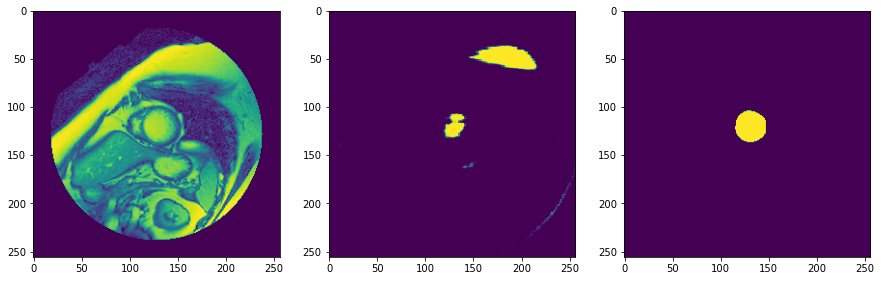

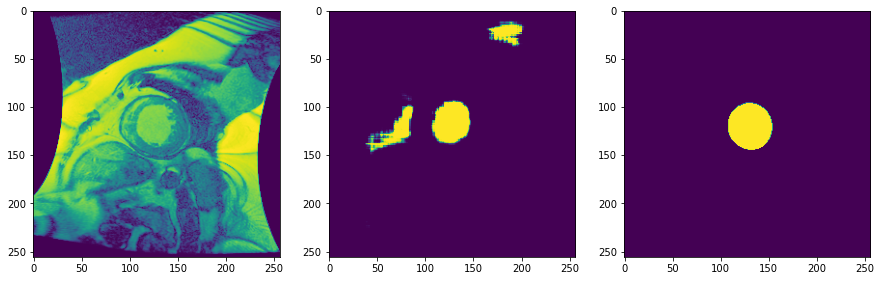

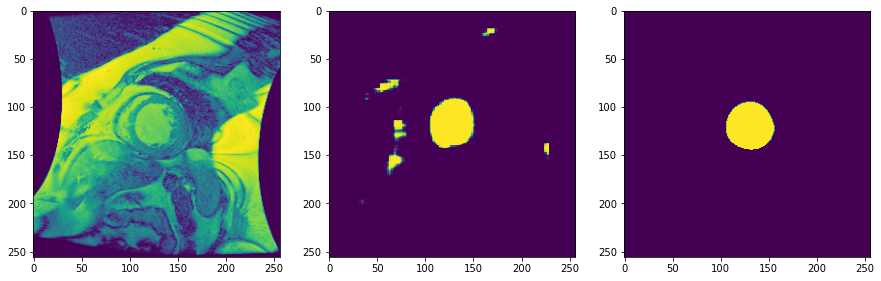

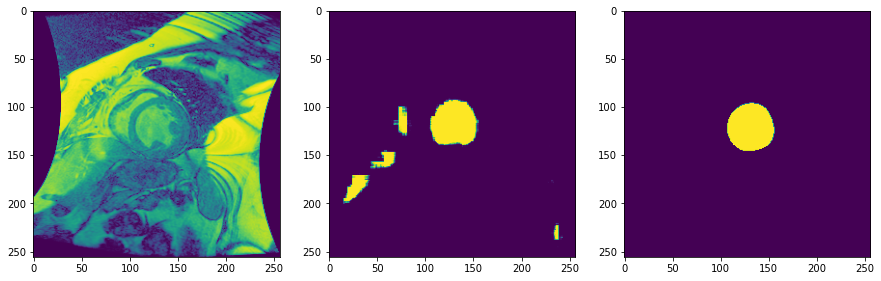

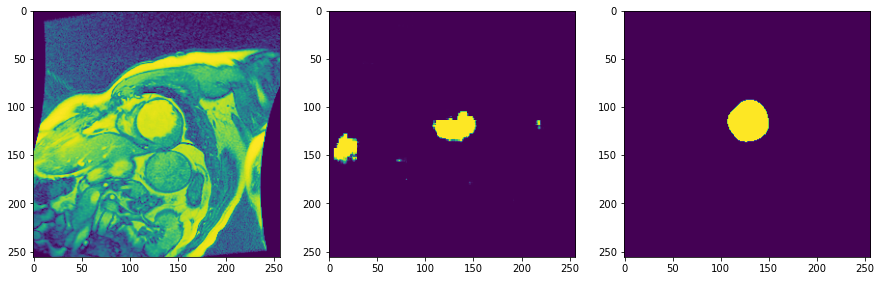

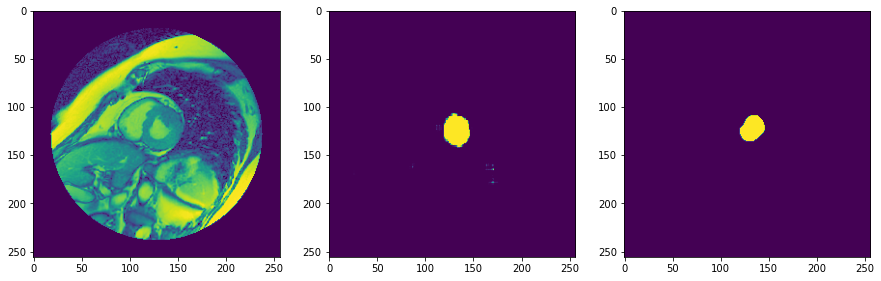

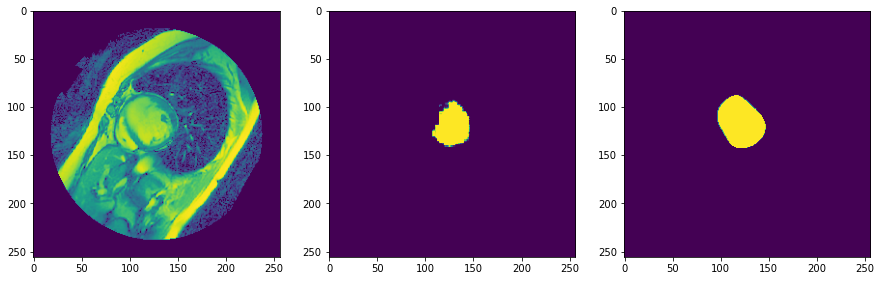

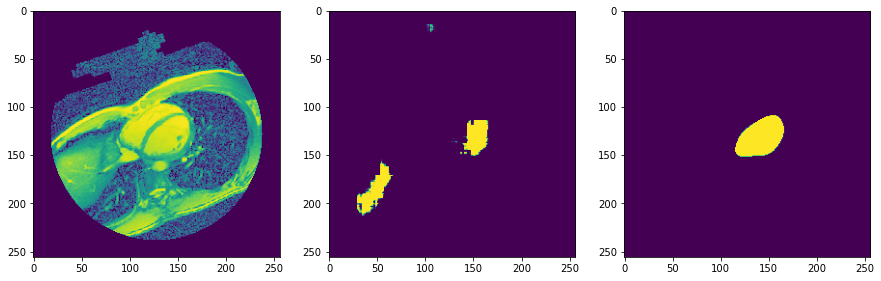

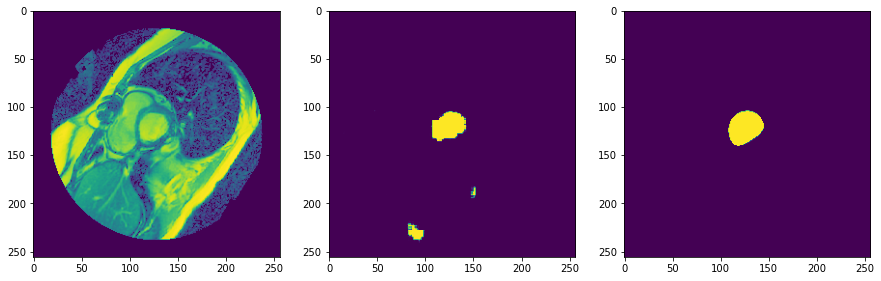

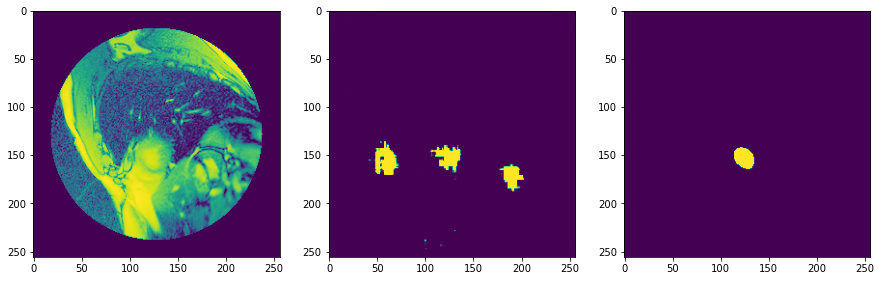

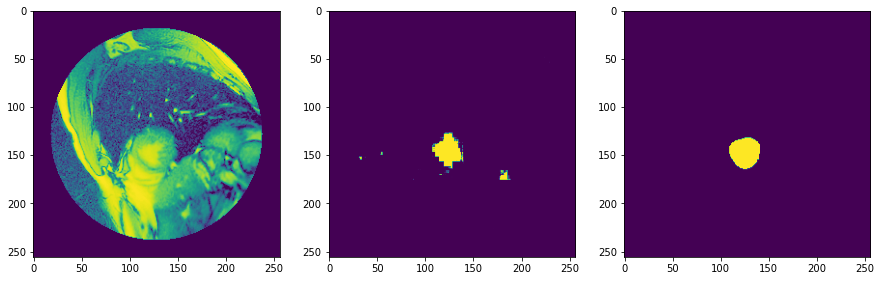

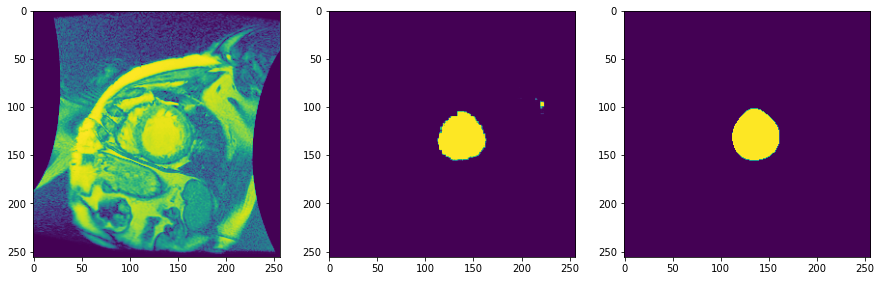

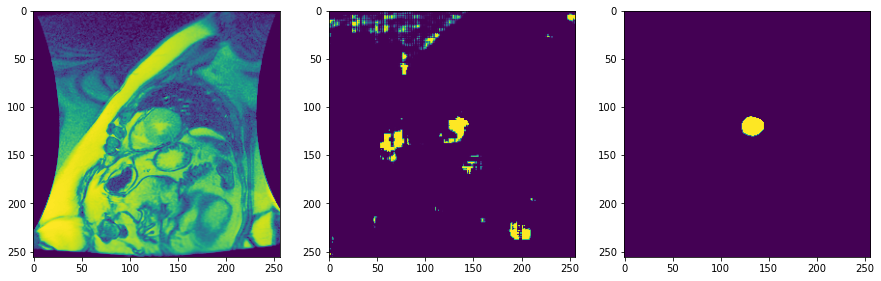

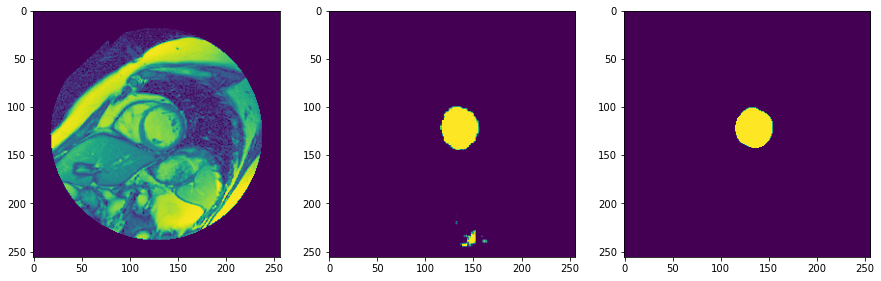

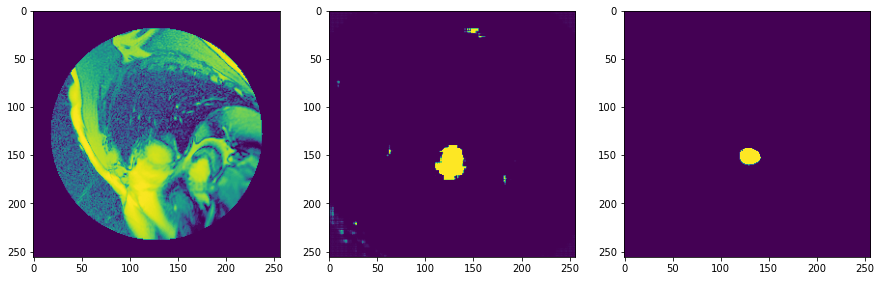

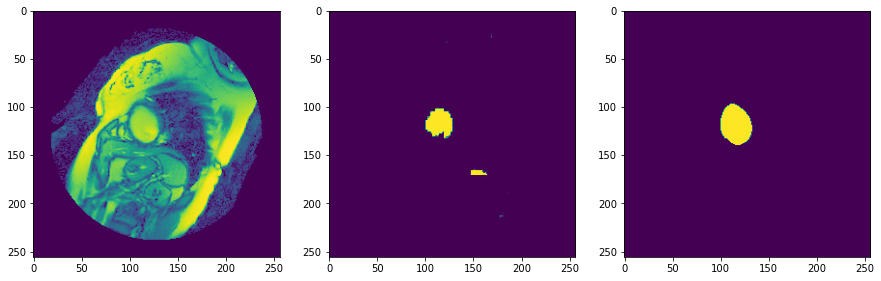

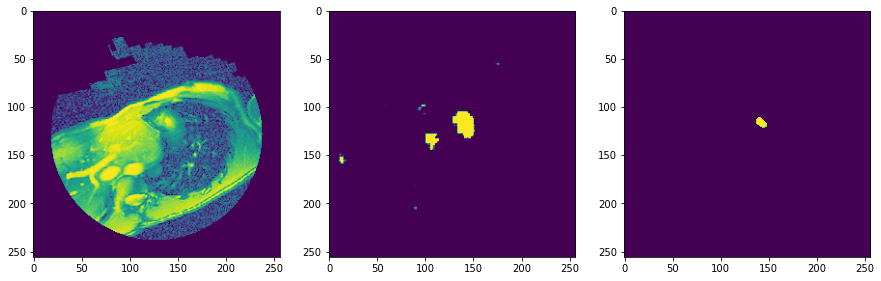

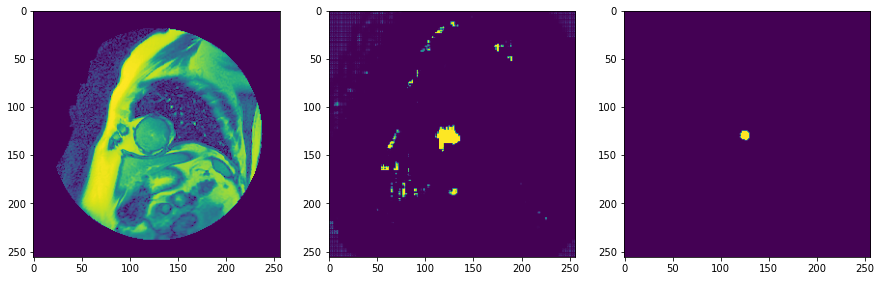

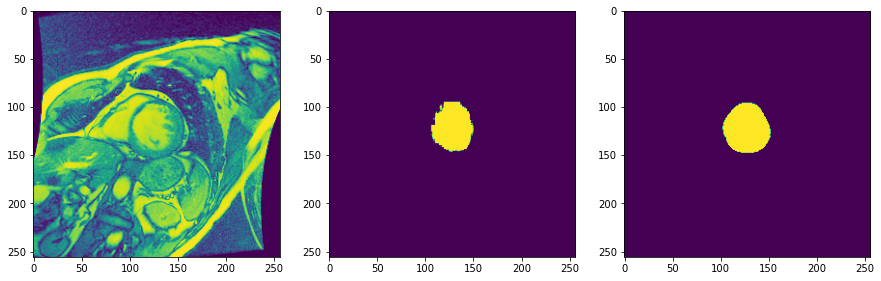

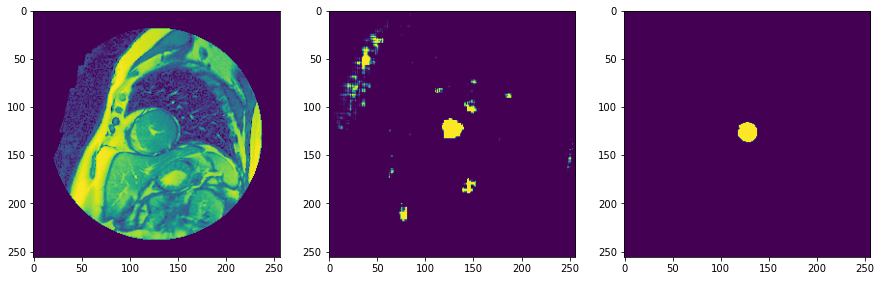

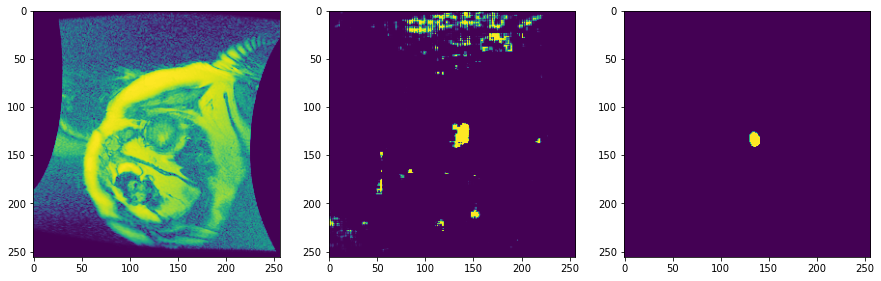

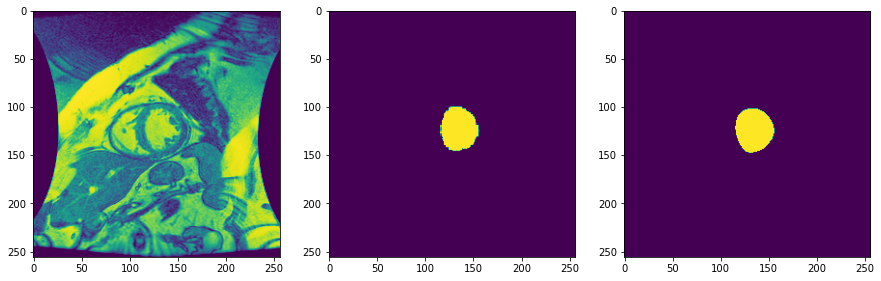

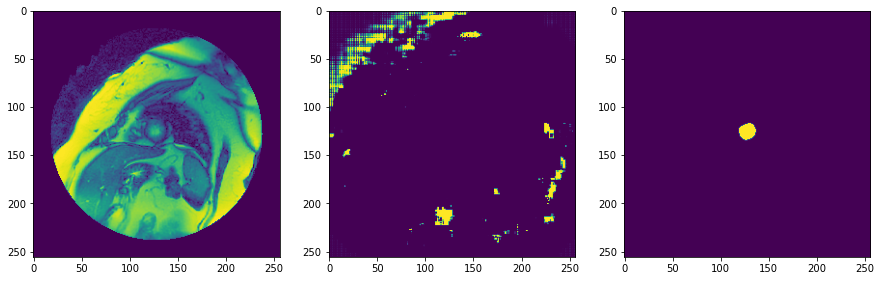

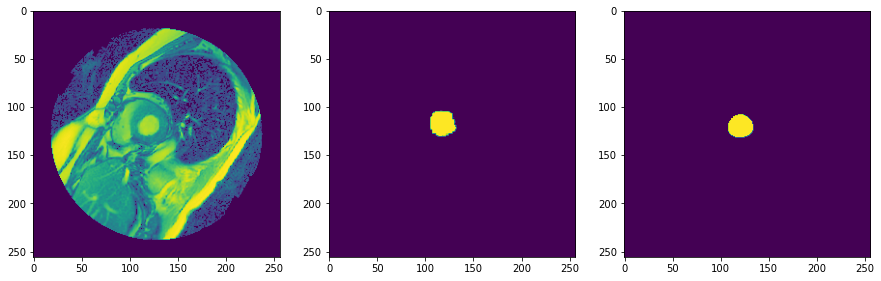

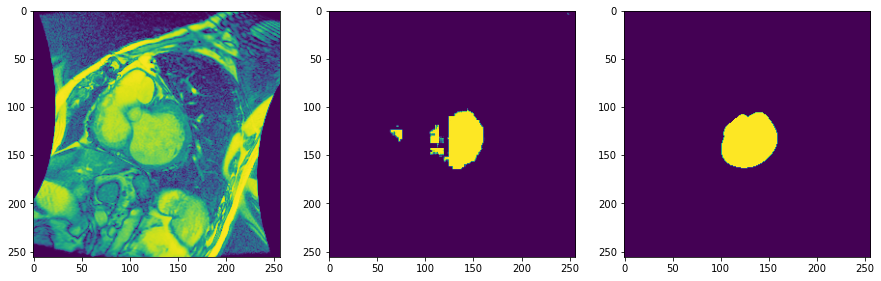

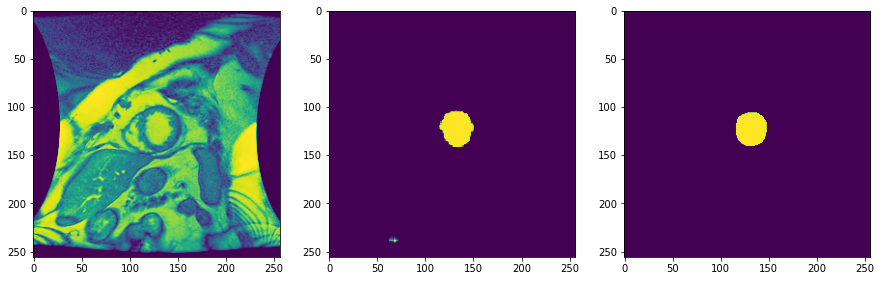

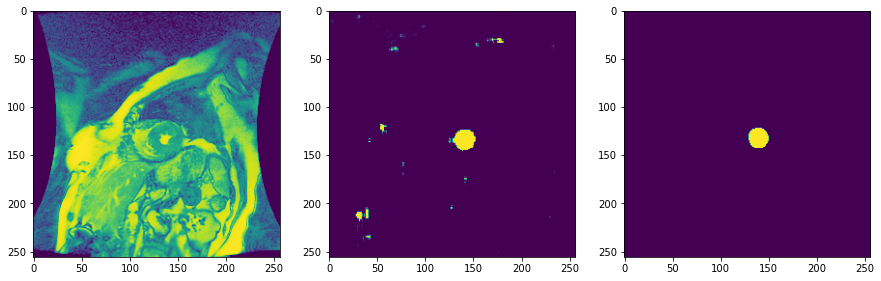

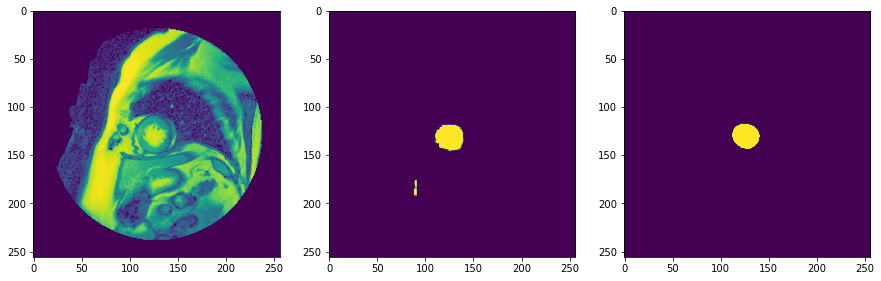

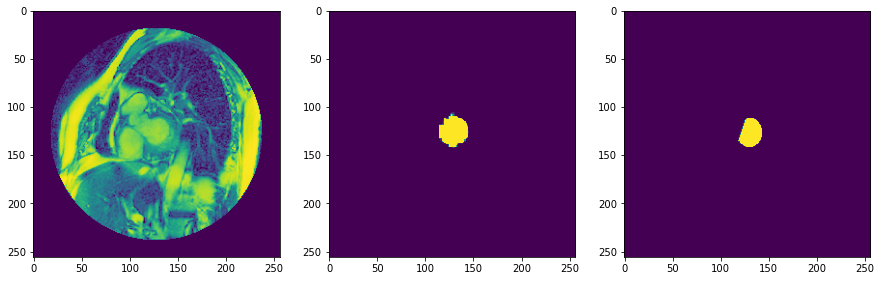

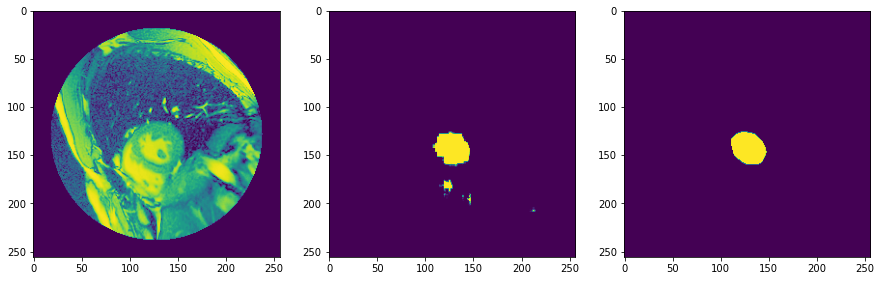

In [25]:
NUM_EPOCHS = config["Epochs"]

print("[INFO] training in progress ...")

start_time = time.time()

model = model.to(device)

for e in tqdm(range(NUM_EPOCHS)):

  model.train()

  total_train_loss = 0
  total_valid_loss = 0

  total_train_dice = 0
  total_valid_dice = 0

  total_train_IoU = 0
  total_valid_IoU = 0

  for (i, (x, y)) in enumerate(train_dataloader):
    
    optimizer.zero_grad()
    (x,y) = (x.to(device),y.to(device))

    pred = model(x)
    

    loss = loss_function(pred,y)
    
    loss.backward()

    optimizer.step()
    #pred = nn.Sigmoid()(pred)
    total_train_loss += loss.item()
    total_train_dice += dice_metric(pred,y).item()
    total_train_IoU  += IoU_metric(pred,y).item()

  with torch.no_grad():

    #model.eval()

    for (i, (x, y)) in enumerate(valid_dataloader):

      pred = model(x)

      total_valid_loss += loss_function(pred, y).item()
      #pred = nn.Sigmoid()(pred)
      total_valid_dice += dice_metric(pred,y).item()
      total_valid_IoU  += IoU_metric(pred,y).item()

  train_loss = total_train_loss / len(train_dataloader)
  valid_loss = total_valid_loss / len(valid_dataloader)

  train_dice = total_train_dice / len(train_dataloader)
  valid_dice = total_valid_dice / len(valid_dataloader)

  train_IoU  = total_train_IoU / len(train_dataloader)
  valid_IoU  = total_valid_IoU / len(valid_dataloader)


  H["train_loss"].append(train_loss)
  H["valid_loss"].append(valid_loss)

  H["train_dice"].append(train_dice)
  H["valid_dice"].append(valid_dice)

  H["train_IoU"].append(train_IoU)
  H["valid_IoU"].append(valid_IoU)
    
  ######################################################################
  img,label = next(iter(test_dataloader))

  model = model.to(device)
  img = img.to(device)
  output = model.forward(img)
  
  
  img = img.cpu().squeeze()
  output = output.cpu().detach().numpy().squeeze()
  label = label.cpu().squeeze()

  fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

  ax1.imshow(img)
  ax2.imshow(output)
  ax3.imshow(label)
  #fig.colorbar()
  fig.show()
  
  ######################################################################

  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
  print("Train loss: {:.6f}, Valid loss: {:.4f}, Train DICE: {:.4f}, Valid DICE: {:.4f}, Train IoU: {:.4f}, Valid IoU: {:.4f}".format(
      train_loss, valid_loss,train_dice,valid_dice,train_IoU,valid_IoU))
  
end_time = time.time()

print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))

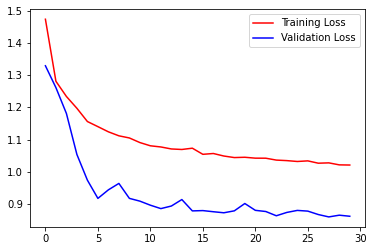

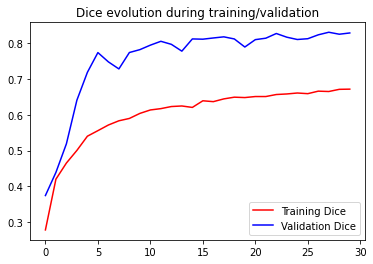

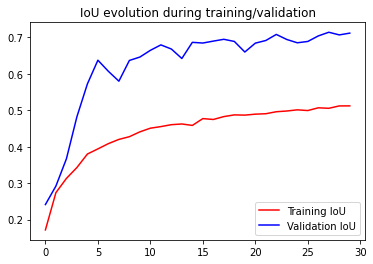

In [26]:
plt.plot(H["train_loss"],'r', label='Training Loss')
plt.plot(H["valid_loss"],'b', label='Validation Loss')
plt.legend()
plt.show()

plt.plot(H["train_dice"],'r', label='Training Dice')
plt.plot(H["valid_dice"],'b', label='Validation Dice')
plt.title("Dice evolution during training/validation")
plt.legend()
plt.show()

plt.plot( H["train_IoU"], 'r', label='Training IoU')
plt.plot(H["valid_IoU"], 'b', label='Validation IoU')
plt.title("IoU evolution during training/validation")
plt.legend()
plt.show()

https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py

In [24]:
model.train()

dice = 0
IoU = 0
model = model.to(device)
for i,(img,label) in enumerate(test_dataloader):
    
    img = img.to(device)
    output = model.forward(img)
    dice += dice_metric(output,label).item()
    IoU += IoU_metric(output,label).item()
    
print(f"Dice_metric avg : {(dice/len(test_dataloader))*100}% , IoU {(IoU/len(test_dataloader))*100:.3f}%")

Dice_metric avg : 83.57620000884069% , IoU 73.833%


In [28]:
test_dir = "Data/Dataset2/manual_contours/images/"
#test_dataset = Dataset_seg(train_dir+"/Images/",train_dir+"/Labels/",transforms.ToTensor())
test_dataset = Dataset_seg(test_dir,valid_dir+"/Labels/",transforms.ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = True)

In [ ]:
model.train()

img,label = next(iter(test_dataloader))

model = model.to(device)
img = img.to(device)
output = model.forward(img)

#print(f"Dice_metric : {dice_metric(output,label)*100:.3f}% , IoU {IoU_metric(output,label)*100:.3f}%")

img = img.cpu().squeeze()
plt.imshow(img)
plt.colorbar()
plt.show()

output = output.cpu().detach().numpy().squeeze()
plt.imshow(output)
plt.colorbar()
plt.show()


#label = label.cpu().squeeze()
#plt.imshow(label)
#plt.colorbar()

plt.show()


#img = wandb.Image(img, caption="Input image")
#label = wandb.Image(label, caption="Mask image")
#output = wandb.Image(output, caption="U-Net output")
          
#wandb.log({"Input": img, "label":label, "output":output})


# Model Saving / Loading

In [25]:
#Model saving

EPOCH = 20
PATH = "Unet_512.pt"
learning_rate = 0.001

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'learning_rate': learning_rate,
            }, PATH)

In [ ]:
PATH = "Unet.pt"

model = Unet()
model = model.to(device)
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>